In [1]:
%load_ext autoreload
%autoreload 2
import copy
import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pyro
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, infer_discrete, autoguide
from pyro import poutine, infer, nn, distributions as dist

plt.style.use('seaborn-v0_8')

/env_nlp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Gaussian Mixture

In [2]:
pyro.set_rng_seed(100)
torch.manual_seed(0)
K = 3
N = 30
w = None
c = 0
while c < 100:
    w = dist.Dirichlet(torch.empty(K).uniform_(0, 2.)).sample()
    if w.min() > 0.25:
        break
clusters = dist.Categorical(w).sample((30,))
locs = dist.Uniform(-5, 5).sample((K, )).sort().values
scales = dist.LogNormal(0, 1.).sample((K,))
components = [dist.Normal(locs[i], scales[i]) for i in range(K)]
mixtures_points = [components[i].sample() for i in clusters]

In [3]:
w, locs, scales

(tensor([0.3893, 0.2703, 0.3404]),
 tensor([-4.1184, -2.4766,  2.6092]),
 tensor([0.3868, 0.5362, 1.4405]))

In [4]:
data = torch.hstack(mixtures_points)

In [5]:
@config_enumerate
def model(data):
    # print("receibed data")
    weights = pyro.sample("weights", dist.Dirichlet(torch.ones(K) / K))
    
    with pyro.plate("mixture", K):
        l = pyro.sample("locs", dist.Normal(-10., 10.))
        s =   pyro.sample("scales", dist.LogNormal(0., 10.))

    with pyro.plate("data", len(data)):
        clusters = pyro.sample("cluster", dist.Categorical(weights))
        model_mixt = pyro.sample("obs", dist.Normal(l[clusters], s[clusters]), 
                          obs=data)
        
    
    return model_mixt  

In [6]:
def init_loc_fn(site):
    if site["name"] == "weights":
        value = torch.ones(K) / K
    elif site["name"] == "scales":
        value = dist.LogNormal(0, data.std()).sample([3])
    elif site["name"] == "locs":
        value = data[torch.multinomial(torch.ones_like(data).div(N), num_samples=3)]
    else:
        raise NotImplementedError
    
    print(site["name"], value)
    return value


def train(data, seed):
    optim = pyro.optim.Adam({"lr": 2e-3})
    elbo = TraceEnum_ELBO(max_plate_nesting=1)
    pyro.clear_param_store()
    pyro.set_rng_seed(seed)
    torch.manual_seed(seed)

    guide = autoguide.AutoDelta(poutine.block(model, 
                                              expose_fn= lambda msg: msg["name"] in ["weights", "locs", "scales"]),
                                init_loc_fn=init_loc_fn)

    losses = []
    svi = SVI(model, guide, optim, elbo)
    
    for i in range(5000):
        losses.append(svi.step(data))
    
    svi.losses = losses
    return svi


weights tensor([0.3333, 0.3333, 0.3333])
locs tensor([-3.8066,  3.3477, -2.2717])
scales tensor([3.8429e-03, 1.0949e+02, 5.1063e-02])
weights tensor([0.3333, 0.3333, 0.3333])
locs tensor([2.3806, 3.1148, 3.9554])
scales tensor([740.7034,   1.3179,   2.5536])
weights tensor([0.3333, 0.3333, 0.3333])
locs tensor([-4.4660, -2.5926, -2.4909])
scales tensor([6.6264e+03, 4.4104e+00, 2.9305e-04])
weights tensor([0.3333, 0.3333, 0.3333])
locs tensor([ 3.3477, -2.5926,  3.1148])
scales tensor([1.8231, 5.8191, 1.4486])


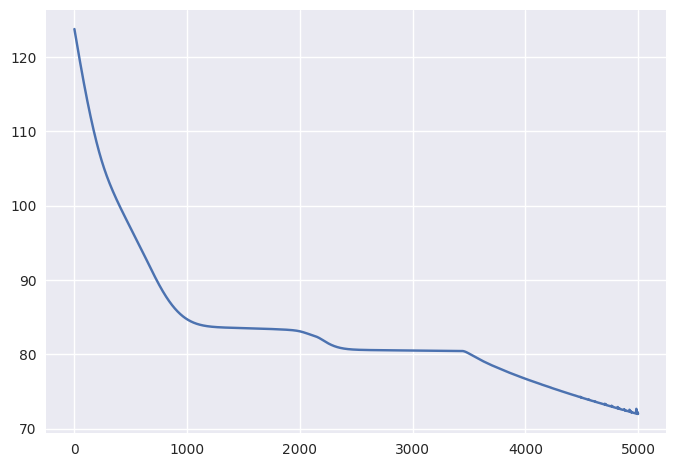

In [7]:
# svi = min([train(data, i) for i in range(50)], key=lambda s: np.mean(s.losses))
svi = min([train(data, i) for i in np.random.choice(100000, (4, ))], key=lambda s: np.min(s.losses))
plt.plot(svi.losses)

In [8]:
param_store = pyro.get_param_store()

In [9]:
list(param_store.items())

[('AutoDelta.weights',
  tensor([0.2988, 0.6899, 0.0113], grad_fn=<DivBackward0>)),
 ('AutoDelta.locs',
  Parameter containing:
  tensor([ 3.4406, -3.5937,  2.2395], requires_grad=True)),
 ('AutoDelta.scales',
  tensor([1.8650e+00, 7.7559e-01, 5.3678e-04], grad_fn=<AddBackward0>))]

In [10]:
w, locs, scales

(tensor([0.3893, 0.2703, 0.3404]),
 tensor([-4.1184, -2.4766,  2.6092]),
 tensor([0.3868, 0.5362, 1.4405]))

In [11]:
guide_trace = poutine.trace(svi.guide).get_trace(data)

In [12]:
guide_trace.nodes

OrderedDict([('_INPUT',
              {'name': '_INPUT',
               'type': 'args',
               'args': (tensor([-2.2717,  3.9554, -4.1576, -4.4058, -3.0122, -2.4909, -4.0826, -2.7928,
                         3.3477, -3.8066, -4.8031,  2.7409, -4.1476, -3.7938, -2.3436, -4.0385,
                        -3.7344, -4.4660,  0.8765,  7.1470, -2.5926,  6.3683, -4.2250, -3.6229,
                         2.3806,  3.1148, -2.5959, -4.4268,  2.2398,  1.6455]),),
               'kwargs': {}}),
             ('mixture',
              {'type': 'sample',
               'name': 'mixture',
               'fn': <pyro.poutine.subsample_messenger._Subsample at 0x7f96a9d6ef70>,
               'is_observed': False,
               'args': (),
               'kwargs': {},
               'value': tensor([0, 1, 2]),
               'infer': {},
               'scale': 1.0,
               'mask': None,
               'cond_indep_stack': (),
               'done': True,
               'stop': False,
     

In [13]:
trained_model = poutine.replay(svi.model, trace=guide_trace)

In [18]:
def classifier(data, temperature=0):
    infered_model = infer_discrete(trained_model, temperature=temperature,
                                   first_available_dim=-2)
    trace = poutine.trace(infered_model).get_trace(data)
    return trace.nodes["cluster"]["value"]
    

In [21]:
new_data = torch.arange(-2, 3, 0.1)
z = classifier(new_data)

In [22]:
z

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])

In [23]:
prev_guide = svi.guide

In [24]:
list(param_store.items())

[('AutoDelta.weights',
  tensor([0.2988, 0.6899, 0.0113], grad_fn=<DivBackward0>)),
 ('AutoDelta.locs',
  Parameter containing:
  tensor([ 3.4406, -3.5937,  2.2395], requires_grad=True)),
 ('AutoDelta.scales',
  tensor([1.8650e+00, 7.7559e-01, 5.3678e-04], grad_fn=<AddBackward0>))]

In [27]:
@config_enumerate
def cluster_guide(data):
    with poutine.block(
        hide_types=["param"]
    ):  
        prev_guide(data)
    
    with pyro.plate("data", len(data)):
        cluster_probs = pyro.param("cluster_probs", torch.ones(K) / K, 
                             constraint=dist.constraints.simplex)
        pyro.sample("cluster", dist.Categorical(cluster_probs))
        

In [28]:
optim = pyro.optim.Adam({"lr": 0.2,})
elbo = TraceEnum_ELBO(max_plate_nesting=1)
new_svi = SVI(model, cluster_guide, optim, loss=elbo)

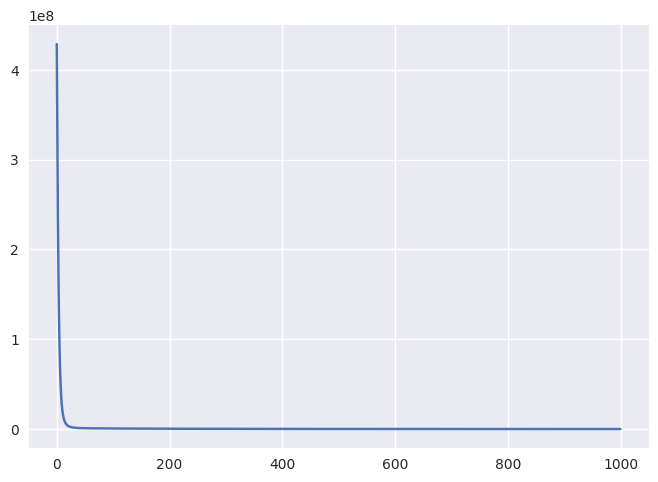

In [29]:
losses = []
for i in range(1000):
    losses.append(new_svi.step(data))
plt.plot(losses)

In [30]:
list(param_store.items())

[('AutoDelta.weights',
  tensor([0.2988, 0.6899, 0.0113], grad_fn=<DivBackward0>)),
 ('AutoDelta.locs',
  Parameter containing:
  tensor([ 3.4406, -3.5937,  2.2395], requires_grad=True)),
 ('AutoDelta.scales',
  tensor([1.8650e+00, 7.7559e-01, 5.3678e-04], grad_fn=<AddBackward0>)),
 ('cluster_probs',
  tensor([5.0101e-01, 4.9896e-01, 3.4865e-05], grad_fn=<DivBackward0>))]

In [4]:
import pyro.contrib.examples.polyphonic_data_loader as poly


In [5]:
data = poly.load_data(poly.JSB_CHORALES)

processing raw data - jsb_chorales ...
dumped processed data to /env_nlp/lib/python3.9/site-packages/pyro/contrib/examples/.data/jsb_chorales.pkl


In [7]:
data["train"]

{'sequence_lengths': tensor([129,  65,  49,  65, 114,  33,  57,  49,  64,  33, 108,  48,  49,  48,
          61,  48,  65,  53,  41,  52,  33,  61,  41,  45,  69,  39,  57,  80,
          86,  57,  61, 105,  68,  65,  48,  57,  57,  52,  48,  33,  93,  41,
          65,  49,  73,  48,  33,  45,  65,  52,  49, 109,  49,  52,  65,  41,
          49,  65,  77,  73,  57,  41,  65,  57,  44,  33,  85,  72,  60,  41,
          49,  33,  56,  52,  56,  83,  57,  57,  52,  41,  53,  64,  61,  65,
          65,  48,  25,  96,  41,  37,  76,  65,  65,  72,  41,  65,  41,  37,
          77,  48,  85,  57,  72,  48,  45,  53,  49,  84,  68,  49,  73,  50,
          96,  55,  66,  98,  37,  76,  65,  33,  49,  77,  76,  65, 128,  41,
          45,  61,  33,  88,  61,  63,  65,  68,  60,  49,  48,  45,  65,  45,
          33,  64,  64,  65,  49,  63,  61,  48,  45,  65,  84, 120,  41, 102,
          49,  57,  69,  57,  82,  48,  76,  48,  52, 113,  97,  83,  33,  68,
          41,  49,  65, 109, 108

In [12]:
data["train"]["sequence_lengths"]

tensor([129,  65,  49,  65, 114,  33,  57,  49,  64,  33, 108,  48,  49,  48,
         61,  48,  65,  53,  41,  52,  33,  61,  41,  45,  69,  39,  57,  80,
         86,  57,  61, 105,  68,  65,  48,  57,  57,  52,  48,  33,  93,  41,
         65,  49,  73,  48,  33,  45,  65,  52,  49, 109,  49,  52,  65,  41,
         49,  65,  77,  73,  57,  41,  65,  57,  44,  33,  85,  72,  60,  41,
         49,  33,  56,  52,  56,  83,  57,  57,  52,  41,  53,  64,  61,  65,
         65,  48,  25,  96,  41,  37,  76,  65,  65,  72,  41,  65,  41,  37,
         77,  48,  85,  57,  72,  48,  45,  53,  49,  84,  68,  49,  73,  50,
         96,  55,  66,  98,  37,  76,  65,  33,  49,  77,  76,  65, 128,  41,
         45,  61,  33,  88,  61,  63,  65,  68,  60,  49,  48,  45,  65,  45,
         33,  64,  64,  65,  49,  63,  61,  48,  45,  65,  84, 120,  41, 102,
         49,  57,  69,  57,  82,  48,  76,  48,  52, 113,  97,  83,  33,  68,
         41,  49,  65, 109, 108,  60,  65,  57,  49,  33,  57,  

In [10]:
data["train"]["sequences"].size()

torch.Size([229, 129, 88])

In [14]:
ex = data["train"]["sequences"][1]

In [17]:
ex.size()

torch.Size([129, 88])

In [15]:
ex

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [16]:
ex[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [18]:
ex[1]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [21]:
ex[65:].sum()

tensor(0.)

In [22]:
ex[64]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [23]:
sequences = data["train"]["sequences"]
lengths = data["train"]["sequence_lengths"]

# find all the notes that are present at least once in the training set
present_notes = (sequences == 1).sum(0).sum(0) > 0
# remove notes that are never played (we remove 37/88 notes)
sequences = sequences[..., present_notes]

In [25]:
sequences.size()

torch.Size([229, 129, 51])

In [26]:
num_observations = float(lengths.sum())
num_observations

13807.0

In [27]:
num_sequences, max_length, data_dim = sequences.shape


In [28]:
num_sequences

229

In [29]:
max_length

129

In [30]:
data_dim

51

In [33]:
dist.Dirichlet(0.9 * torch.eye(16) + 0.1).to_event(1).sample()

tensor([[3.6161e-01, 6.0911e-07, 1.9840e-03, 4.6036e-10, 1.5080e-01, 3.3099e-06,
         1.4890e-05, 5.5664e-07, 2.4926e-02, 2.0698e-02, 9.4012e-02, 4.5392e-08,
         9.6835e-29, 3.4595e-01, 7.2783e-14, 8.1011e-07],
        [1.0847e-06, 3.0679e-01, 3.9628e-02, 1.1167e-09, 1.6784e-07, 1.7937e-10,
         1.3159e-03, 8.1377e-06, 3.6302e-03, 1.4684e-04, 3.1064e-01, 5.0675e-06,
         2.0058e-01, 1.3716e-01, 8.7989e-05, 2.8809e-07],
        [6.4479e-02, 4.3550e-01, 6.4081e-02, 3.6200e-01, 3.1735e-06, 1.5437e-06,
         2.7385e-07, 9.4056e-03, 1.4669e-03, 4.9832e-09, 1.2236e-08, 1.1957e-07,
         1.8149e-03, 4.1483e-12, 1.4793e-02, 4.6454e-02],
        [1.2897e-06, 1.4855e-06, 1.0692e-06, 2.1151e-01, 5.8647e-02, 7.1553e-04,
         4.6889e-05, 4.0958e-03, 5.6374e-02, 3.1083e-01, 6.0637e-04, 1.9875e-01,
         1.2005e-02, 1.4627e-01, 1.4423e-04, 6.9613e-23],
        [2.3629e-01, 2.0715e-06, 1.7326e-02, 2.2014e-11, 3.6482e-02, 4.9211e-07,
         1.4110e-02, 1.9165e-12, 1.5758

In [35]:
dist.Dirichlet(0.9 * torch.eye(16) + 0.1).to_event(1).sample().max(1)

torch.return_types.max(
values=tensor([0.5948, 0.8845, 0.4677, 0.6039, 0.4931, 0.6813, 0.6623, 0.4022, 0.4396,
        0.7509, 0.8897, 0.3788, 0.3210, 0.7410, 0.7441, 0.4033]),
indices=tensor([ 0,  1,  2,  3,  4,  3,  4,  1,  8,  9, 10, 10,  7, 13, 14,  4]))